In [9]:
import numpy as np
from scipy import stats
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from collections import Counter

class MCMCFeatureSelection:
    """
    Bayesian Feature Selection using Markov Chain Monte Carlo

    This class implements a MCMC approach to feature selection by
    sampling from the posterior distribution over feature subsets.
    """

    def __init__(self, n_iterations=5000, burnin=1000, p_add=0.4, p_remove=0.4, p_swap=0.2,
                 prior_type='binomial', prior_params=None):
        """
        Initialize the MCMC Feature Selection model.

        Parameters:
        -----------
        n_iterations : int
            Number of MCMC iterations
        burnin : int
            Number of initial samples to discard (burn-in period)
        p_add : float
            Probability of proposing to add a feature
        p_remove : float
            Probability of proposing to remove a feature
        p_swap : float
            Probability of proposing to swap a feature
        prior_type : str
            Type of prior distribution ('uniform', 'binomial', 'custom')
        prior_params : dict or None
            Additional parameters for the prior distribution
        """
        self.n_iterations = n_iterations
        self.burnin = burnin
        self.p_add = p_add
        self.p_remove = p_remove
        self.p_swap = p_swap
        self.prior_type = prior_type
        self.prior_params = prior_params if prior_params else {}

        # Check that proposal probabilities sum to 1
        assert abs(p_add + p_remove + p_swap - 1.0) < 1e-10, "Proposal probabilities must sum to 1"

        # Results storage
        self.feature_probabilities = None
        self.samples = None
        self.best_subset = None

    def _calculate_prior(self, subset, n_features):
        """Calculate prior probability for a feature subset."""
        if self.prior_type == 'uniform':
            # All subsets equally likely
            return 0.0  # log prior

        elif self.prior_type == 'binomial':
            # Binomial prior - favors smaller subsets
            p = self.prior_params.get('p', 0.2)
            subset_size = len(subset)
            # Log PMF for computational stability
            return stats.binom.logpmf(subset_size, n_features, p)

        elif self.prior_type == 'custom':
            # Custom prior provided by user
            if 'func' in self.prior_params:
                return np.log(self.prior_params['func'](subset, n_features))
            else:
                return 0.0

        return 0.0

    def _calculate_log_likelihood(self, X, y, subset):
        """
        Calculate the log likelihood for a given feature subset.
        Uses Bayesian Ridge Regression.
        """
        if len(subset) == 0:
            return float('-inf')

        # Extract features for this subset
        X_subset = X[:, list(subset)]

        # Fit Bayesian model
        model = BayesianRidge(fit_intercept=True, compute_score=True)
        model.fit(X_subset, y)

        # Use model score as proxy for log likelihood
        return model.score(X_subset, y)

    def _calculate_log_posterior(self, X, y, subset, n_features):
        """Calculate log posterior probability for a feature subset."""
        log_prior = self._calculate_prior(subset, n_features)
        log_likelihood = self._calculate_log_likelihood(X, y, subset)
        return log_prior + log_likelihood

    def _propose_new_subset(self, current_subset, n_features):
        """Propose a new feature subset based on current subset."""
        # Convert to set for easier manipulation
        current = set(current_subset)
        available = set(range(n_features)) - current

        # Randomly choose proposal type
        proposal_type = np.random.choice(['add', 'remove', 'swap'],
                                        p=[self.p_add, self.p_remove, self.p_swap])

        if proposal_type == 'add' and available:
            # Add a random feature
            feature_to_add = np.random.choice(list(available))
            return current | {feature_to_add}

        elif proposal_type == 'remove' and current:
            # Remove a random feature
            feature_to_remove = np.random.choice(list(current))
            return current - {feature_to_remove}

        elif proposal_type == 'swap' and current and available:
            # Swap a random feature
            feature_to_remove = np.random.choice(list(current))
            feature_to_add = np.random.choice(list(available))
            return (current - {feature_to_remove}) | {feature_to_add}

        # If the chosen proposal doesn't work (e.g., trying to remove from empty set),
        # return the current subset unchanged
        return current

    def fit(self, X, y, initial_subset=None):
        """
        Fit the MCMC Feature Selection model.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The training input samples
        y : array-like of shape (n_samples,)
            The target values
        initial_subset : set or None
            Initial feature subset to start MCMC chain

        Returns:
        --------
        self : object
            Returns self
        """
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape

        # Initialize with a random subset if not provided
        if initial_subset is None:
            initial_size = max(1, n_features // 10)  # Start with ~10% of features
            initial_subset = set(np.random.choice(n_features, size=initial_size, replace=False))

        # Initialize storage for MCMC samples
        self.samples = []
        current_subset = initial_subset
        current_log_posterior = self._calculate_log_posterior(X, y, current_subset, n_features)

        # Run MCMC
        for i in range(self.n_iterations):
            # Propose a new subset
            proposed_subset = self._propose_new_subset(current_subset, n_features)

            # Skip if the proposal didn't change anything
            if proposed_subset == current_subset:
                self.samples.append(current_subset)
                continue

            # Calculate posterior for proposed subset
            proposed_log_posterior = self._calculate_log_posterior(X, y, proposed_subset, n_features)

            # Metropolis-Hastings acceptance ratio (in log space)
            log_acceptance_ratio = proposed_log_posterior - current_log_posterior

            # Accept or reject
            if np.log(np.random.random()) < min(0, log_acceptance_ratio):
                current_subset = proposed_subset
                current_log_posterior = proposed_log_posterior

            # Store the sample (post burn-in)
            if i >= self.burnin:
                self.samples.append(frozenset(current_subset))

        # Calculate feature inclusion probabilities
        post_burnin_samples = self.samples[self.burnin:]
        feature_counts = Counter()

        for subset in post_burnin_samples:
            for feature in subset:
                feature_counts[feature] += 1

        # Convert to probabilities
        n_samples = len(post_burnin_samples)
        self.feature_probabilities = np.zeros(n_features)

        for feature, count in feature_counts.items():
            self.feature_probabilities[feature] = count / n_samples

        # Find the most common subset
        subset_counts = Counter(post_burnin_samples)
        self.best_subset = list(subset_counts.most_common(1)[0][0])

        return self

    def transform(self, X, threshold=0.5):
        """
        Transform X by selecting features with inclusion probability > threshold.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        threshold : float
            Probability threshold for feature inclusion

        Returns:
        --------
        X_new : array-like of shape (n_samples, n_selected_features)
            The input samples with only the selected features
        """
        if self.feature_probabilities is None:
            raise ValueError("Model must be fitted before transform")

        # Select features based on inclusion probabilities
        selected_features = np.where(self.feature_probabilities >= threshold)[0]

        # If no features meet the threshold, use the best subset
        if len(selected_features) == 0:
            selected_features = self.best_subset

        return X[:, selected_features]

    def fit_transform(self, X, y, threshold=0.5, initial_subset=None):
        """
        Fit to data, then transform it.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The training input samples
        y : array-like of shape (n_samples,)
            The target values
        threshold : float
            Probability threshold for feature inclusion
        initial_subset : set or None
            Initial feature subset to start MCMC chain

        Returns:
        --------
        X_new : array-like of shape (n_samples, n_selected_features)
            The input samples with only the selected features
        """
        return self.fit(X, y, initial_subset).transform(X, threshold)

    def get_feature_importance(self):
        """
        Get the importance of each feature based on inclusion probabilities.

        Returns:
        --------
        feature_importance : array of shape (n_features,)
            The feature importance values
        """
        if self.feature_probabilities is None:
            raise ValueError("Model must be fitted before getting feature importance")

        return self.feature_probabilities

    def plot_feature_importance(self, feature_names=None, top_n=None):
        """
        Plot feature importance based on inclusion probabilities.

        Parameters:
        -----------
        feature_names : list or None
            Names of features for the plot
        top_n : int or None
            Number of top features to plot
        """
        importances = self.get_feature_importance()
        indices = np.argsort(importances)[::-1]

        if top_n is not None:
            indices = indices[:top_n]

        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(len(importances))]

        plt.figure(figsize=(10, 6))
        plt.title("Feature Inclusion Probabilities (MCMC)")
        plt.bar(range(len(indices)), importances[indices], align="center")
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.xlim([-1, len(indices)])
        plt.tight_layout()
        plt.show()

    def plot_trace(self, feature_idx=None, burn_in=True):
        """
        Plot MCMC trace for a specific feature or subset size.

        Parameters:
        -----------
        feature_idx : int or None
            If provided, plots inclusion of this feature across iterations
            If None, plots subset size across iterations
        burn_in : bool
            Whether to include burn-in period in the plot
        """
        iterations = range(len(self.samples))

        plt.figure(figsize=(12, 6))

        if feature_idx is not None:
            # Plot whether a specific feature was included in each iteration
            feature_trace = [int(feature_idx in subset) for subset in self.samples]
            plt.plot(iterations, feature_trace)
            plt.title(f"MCMC Trace for Feature {feature_idx}")
            plt.ylabel("Included (1) / Excluded (0)")
        else:
            # Plot subset size over iterations
            size_trace = [len(subset) for subset in self.samples]
            plt.plot(iterations, size_trace)
            plt.title("MCMC Trace of Subset Size")
            plt.ylabel("Number of Features")

        plt.xlabel("Iteration")

        if burn_in and self.burnin > 0:
            plt.axvline(x=self.burnin, color='r', linestyle='--',
                        label=f"Burn-in ({self.burnin} iterations)")
            plt.legend()

        plt.tight_layout()
        plt.show()

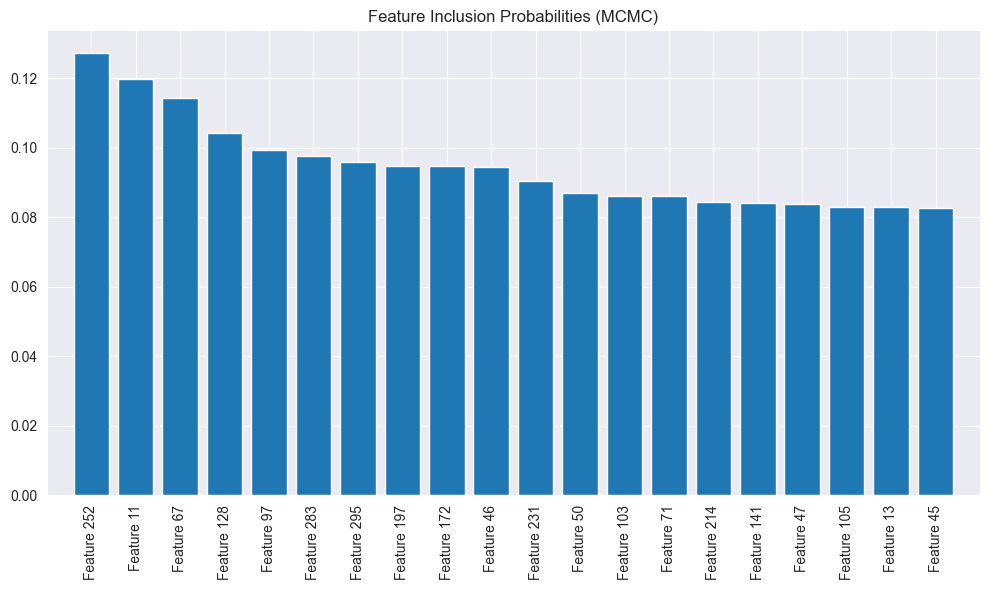

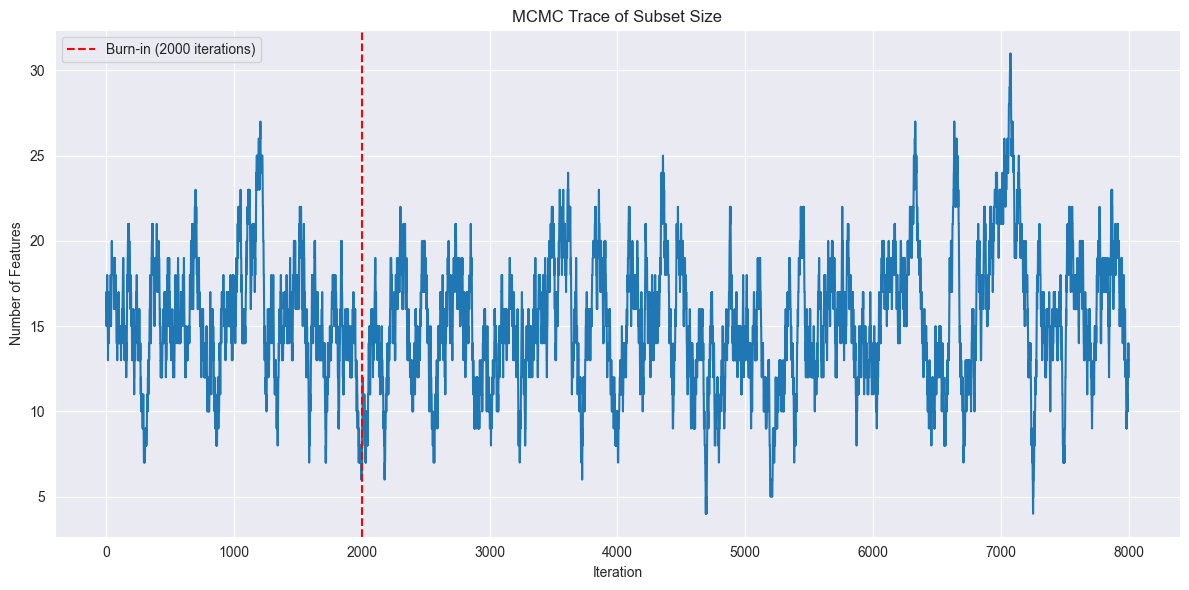

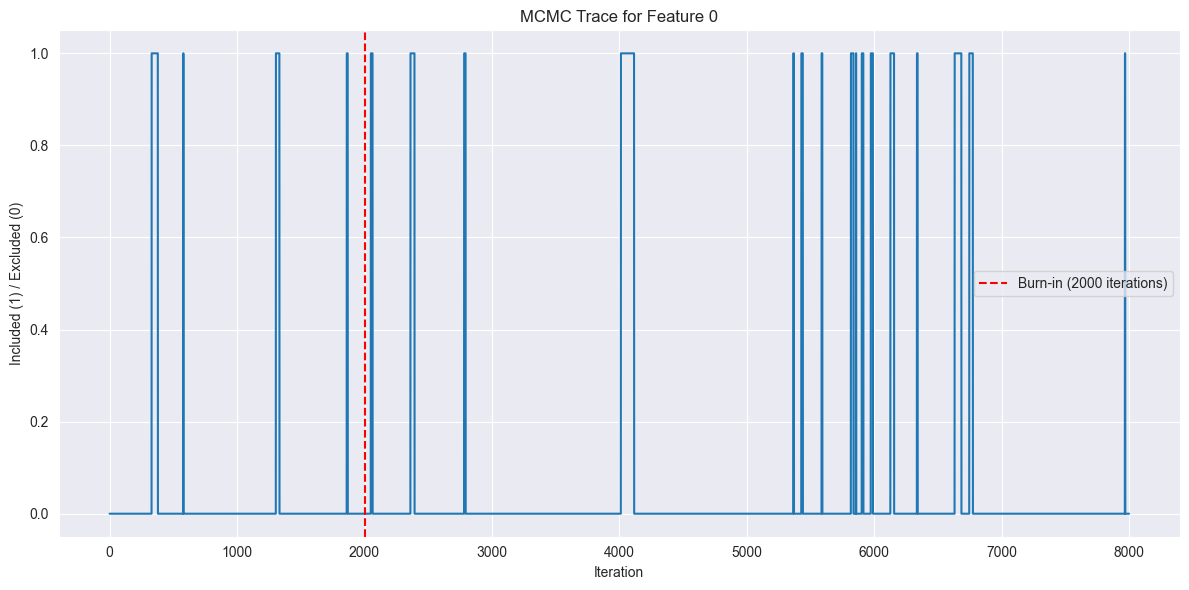

Top 10 features by inclusion probability:
Rank 1: Feature 252 (Prob: 0.1273)
Rank 2: Feature 11 (Prob: 0.1198)
Rank 3: Feature 67 (Prob: 0.1142)
Rank 4: Feature 128 (Prob: 0.1042)
Rank 5: Feature 97 (Prob: 0.0992)
Rank 6: Feature 283 (Prob: 0.0977)
Rank 7: Feature 295 (Prob: 0.0958)
Rank 8: Feature 197 (Prob: 0.0948)
Rank 9: Feature 172 (Prob: 0.0947)
Rank 10: Feature 46 (Prob: 0.0943)

Selected 19 features out of 100

True features: [ 0  5 20 50 80]
Selected features: []


In [10]:
import pandas as pd
# Example usage
if __name__ == "__main__":

    X: pd.DataFrame = pd.read_csv("../../X_train.csv")
    y: pd.DataFrame = pd.read_csv("../../y_train.csv")

    y = y.to_numpy().reshape(-1)
    X = X.to_numpy()

    # Create and fit the MCMC model
    mcmc_fs = MCMCFeatureSelection(n_iterations=10000, burnin=2000,
                                   prior_type='binomial', prior_params={'p': 0.05})
    mcmc_fs.fit(X, y)

    # Plot feature importance for top features
    mcmc_fs.plot_feature_importance(top_n=20)

    # Plot MCMC trace
    mcmc_fs.plot_trace()  # Subset size trace

    # Plot trace for a specific feature
    mcmc_fs.plot_trace(feature_idx=0)

    # Print feature probabilities for the top 10 features
    importance = mcmc_fs.get_feature_importance()
    top_indices = np.argsort(importance)[::-1][:10]

    print("Top 10 features by inclusion probability:")
    for rank, idx in enumerate(top_indices, 1):
        print(f"Rank {rank}: Feature {idx} (Prob: {importance[idx]:.4f})")

    # Transform data using selected features
    X_selected = mcmc_fs.transform(X, threshold=0.5)
    print(f"\nSelected {X_selected.shape[1]} features out of {n_features}")

    # Check if we recovered the true features
    selected_indices = np.where(mcmc_fs.feature_probabilities >= 0.5)[0]
    true_indices = np.where(true_weights != 0)[0]

    print("\nTrue features:", true_indices)
    print("Selected features:", selected_indices)